## Preprocessing

In [ ]:
import pandas as pd
from pathlib import Path
import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
import noisereduce as nr

In [6]:
annotations_csv = Path("~/data/kenya_birds/annotations.csv").expanduser()
recordings_path = Path("~/data/kenya_birds/soundscape_data/").expanduser()

print("annotations: ", annotations_csv.exists())
print("recordings: ", recordings_path.exists())

annotations:  True
recordings:  True


In [7]:
df = pd.read_csv(annotations_csv)

df.head(5)

,Filename,Start Time (s),End Time (s),Species eBird Code
0,KEN_001_20211207_153852.flac,67.8,67.8,slcbou1
1,KEN_001_20211207_153852.flac,106.8,106.8,slcbou1
2,KEN_001_20211207_153852.flac,107.5,107.5,hamerk1
3,KEN_001_20211207_153852.flac,118.4,118.4,slcbou1
4,KEN_001_20211207_153852.flac,209.1,209.1,hamerk1


In [8]:
def load_sample(path, center_time, dur=3.0, sr_target=22050):
  return librosa.load(path, sr=sr_target, offset=max(0, center_time - dur/2), duration=dur)

In [9]:
def show_specs(y, sr):
    # STFT
    D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
    D_db = librosa.amplitude_to_db(D, ref=np.max)
    # Mel
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128, 
                                         fmin=280, fmax=7600) # from analysis
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # time frequency reassigned
    freqs, times, tfr_Sxx = librosa.reassigned_spectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)
    tfr_Sxx_db = librosa.power_to_db(tfr_Sxx, amin=1e-2)
    
    plt.figure(figsize=(30,20))
    
    plt.subplot(4,1,1)
    librosa.display.waveshow(y)
    plt.title('Sample')

    plt.subplot(4,1,2)
    librosa.display.specshow(D_db, sr=sr, x_axis='s', y_axis='log')
    plt.title('STFT (dB)')
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(4,1,3)
    librosa.display.specshow(mel_db, sr=sr, x_axis='s', y_axis='mel')
    plt.title('Mel spectrogram (dB)')
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(4,1,4)
    librosa.display.specshow(tfr_Sxx_db, x_axis='s', y_axis="linear")
    plt.title('Time frequency reassigned spec (dB)')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

### Sample

A random sample from the dataset

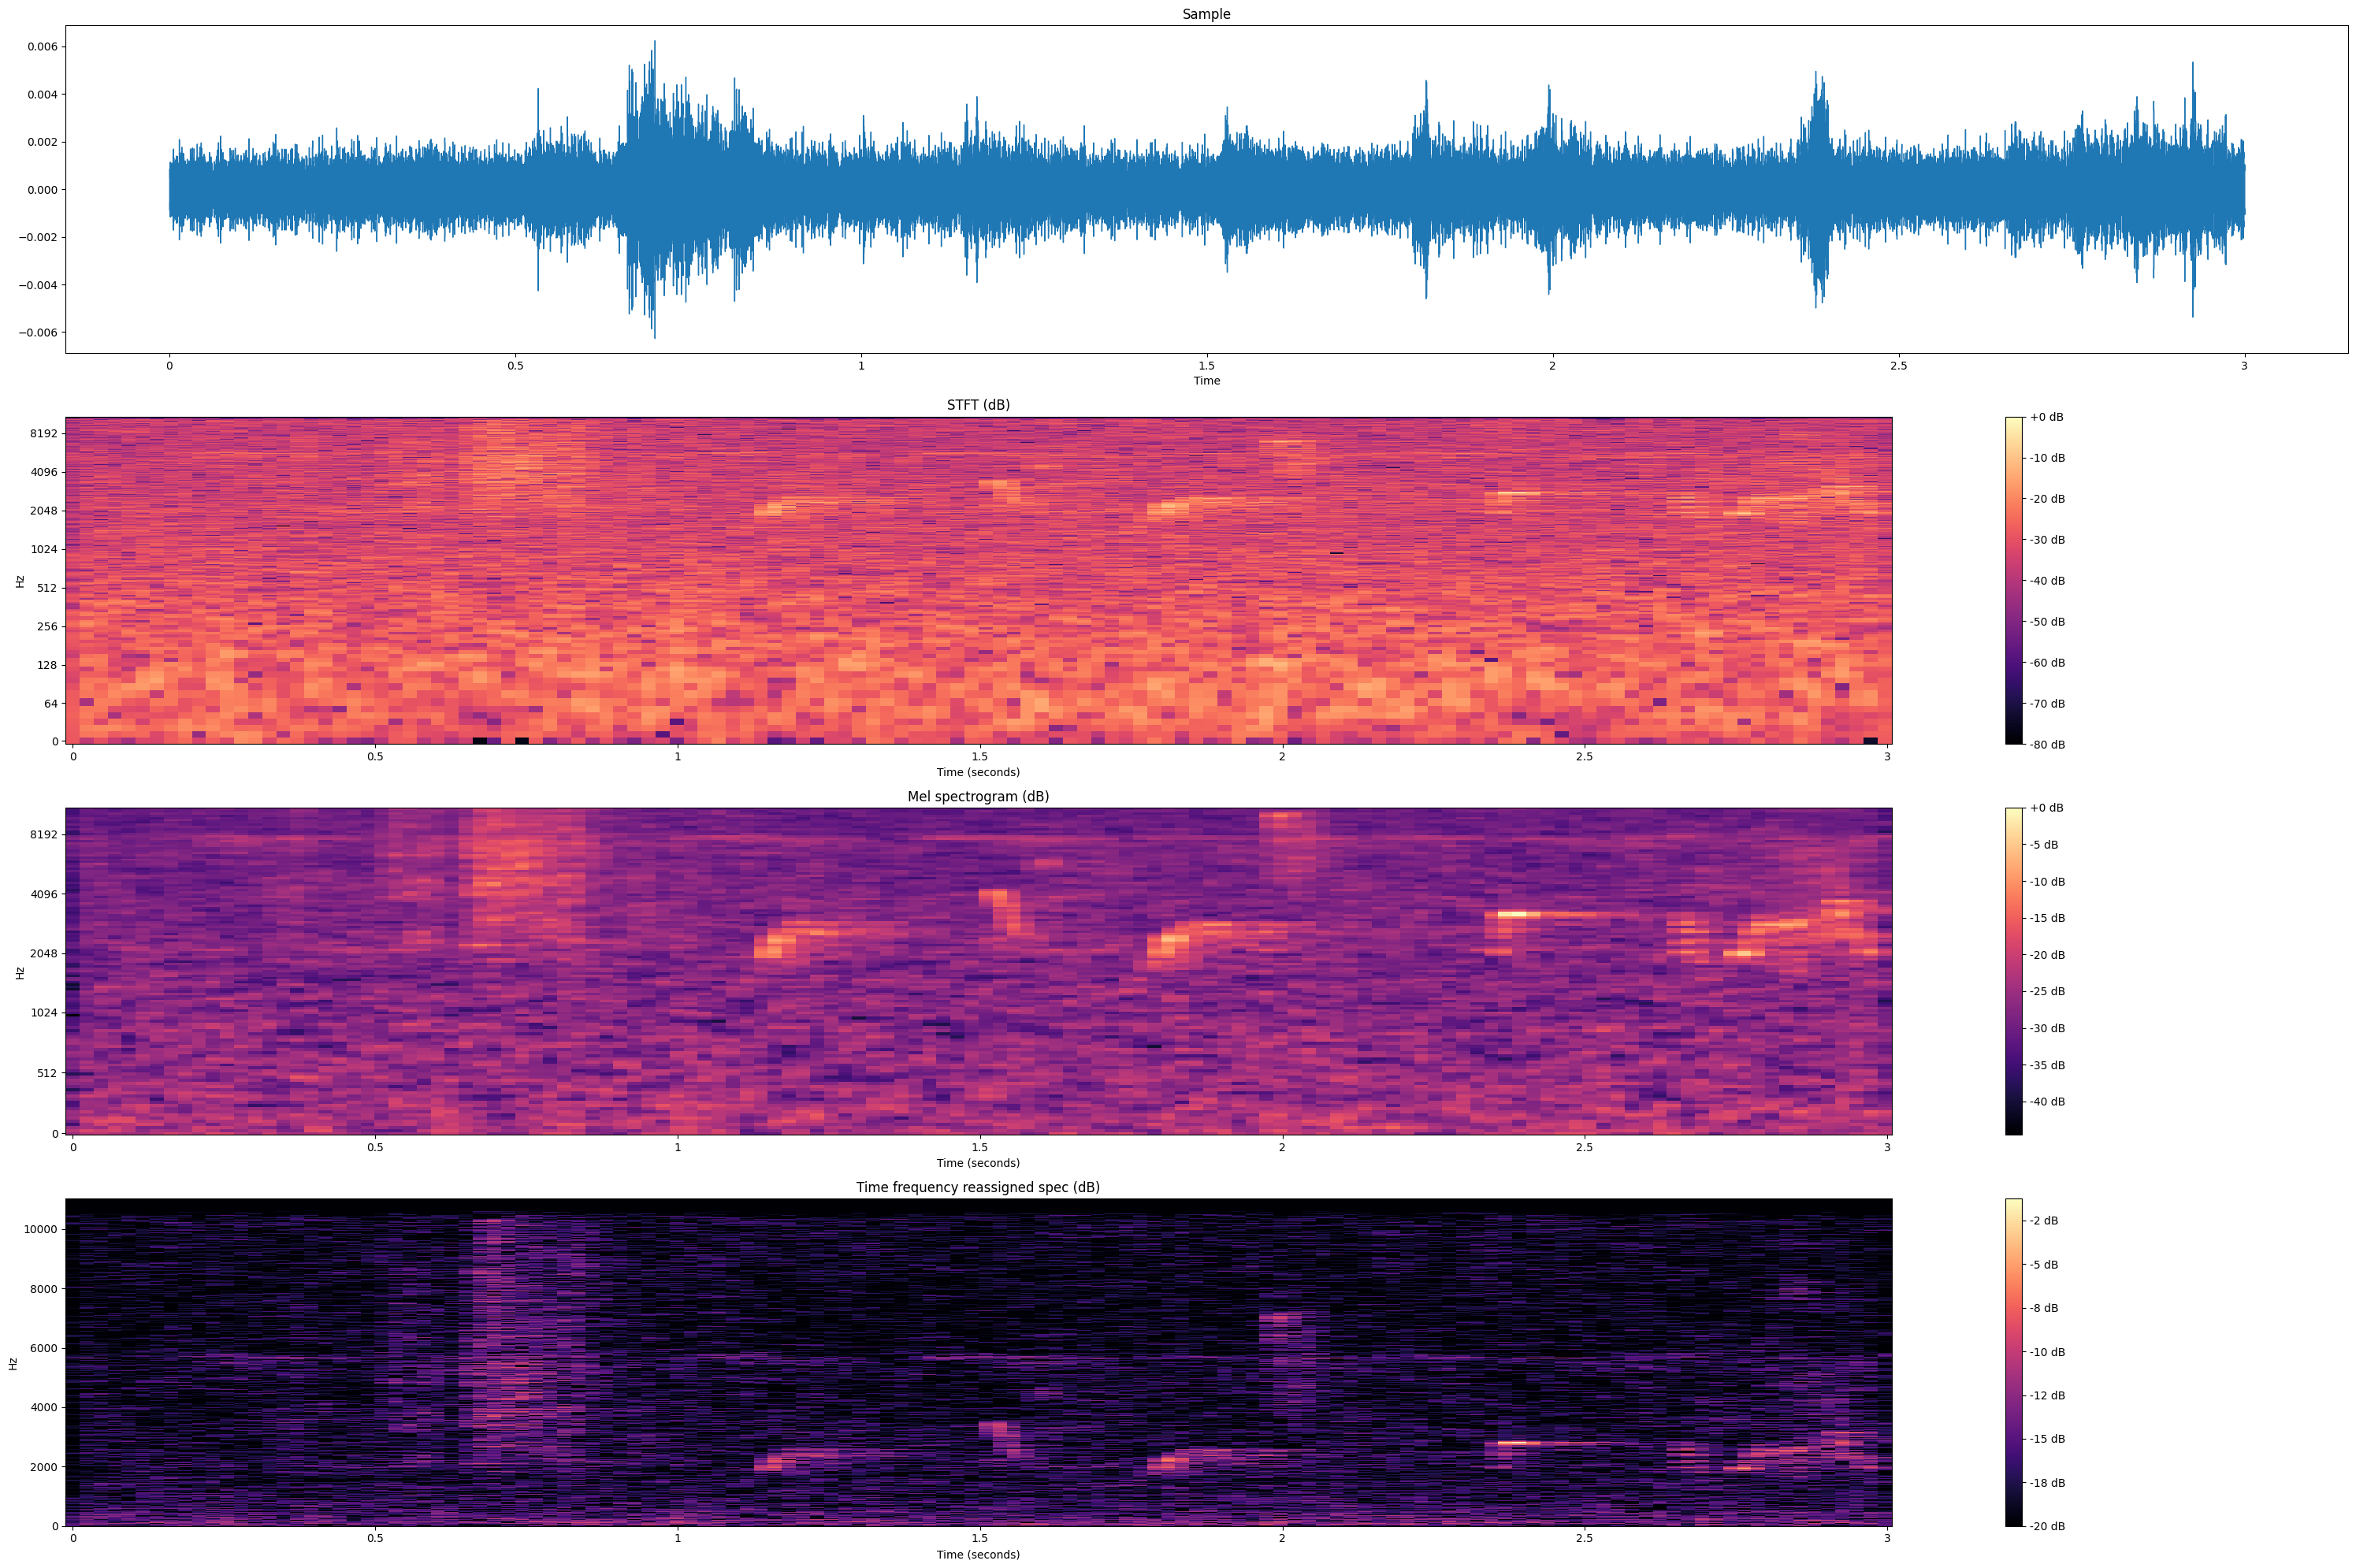

In [10]:
# Example
r = df.sample().iloc[0]
example_file = recordings_path/df['Filename'].mode()[0]
center_time = (r['Start Time (s)'] + r['End Time (s)']) / 2
dur = 3.0  # seconds

# Load slice
y, sr = load_sample(example_file, center_time)

# Display spectrogram
show_specs(y, sr)
display(Audio(y, rate=sr, autoplay=False))

### Noise reduction

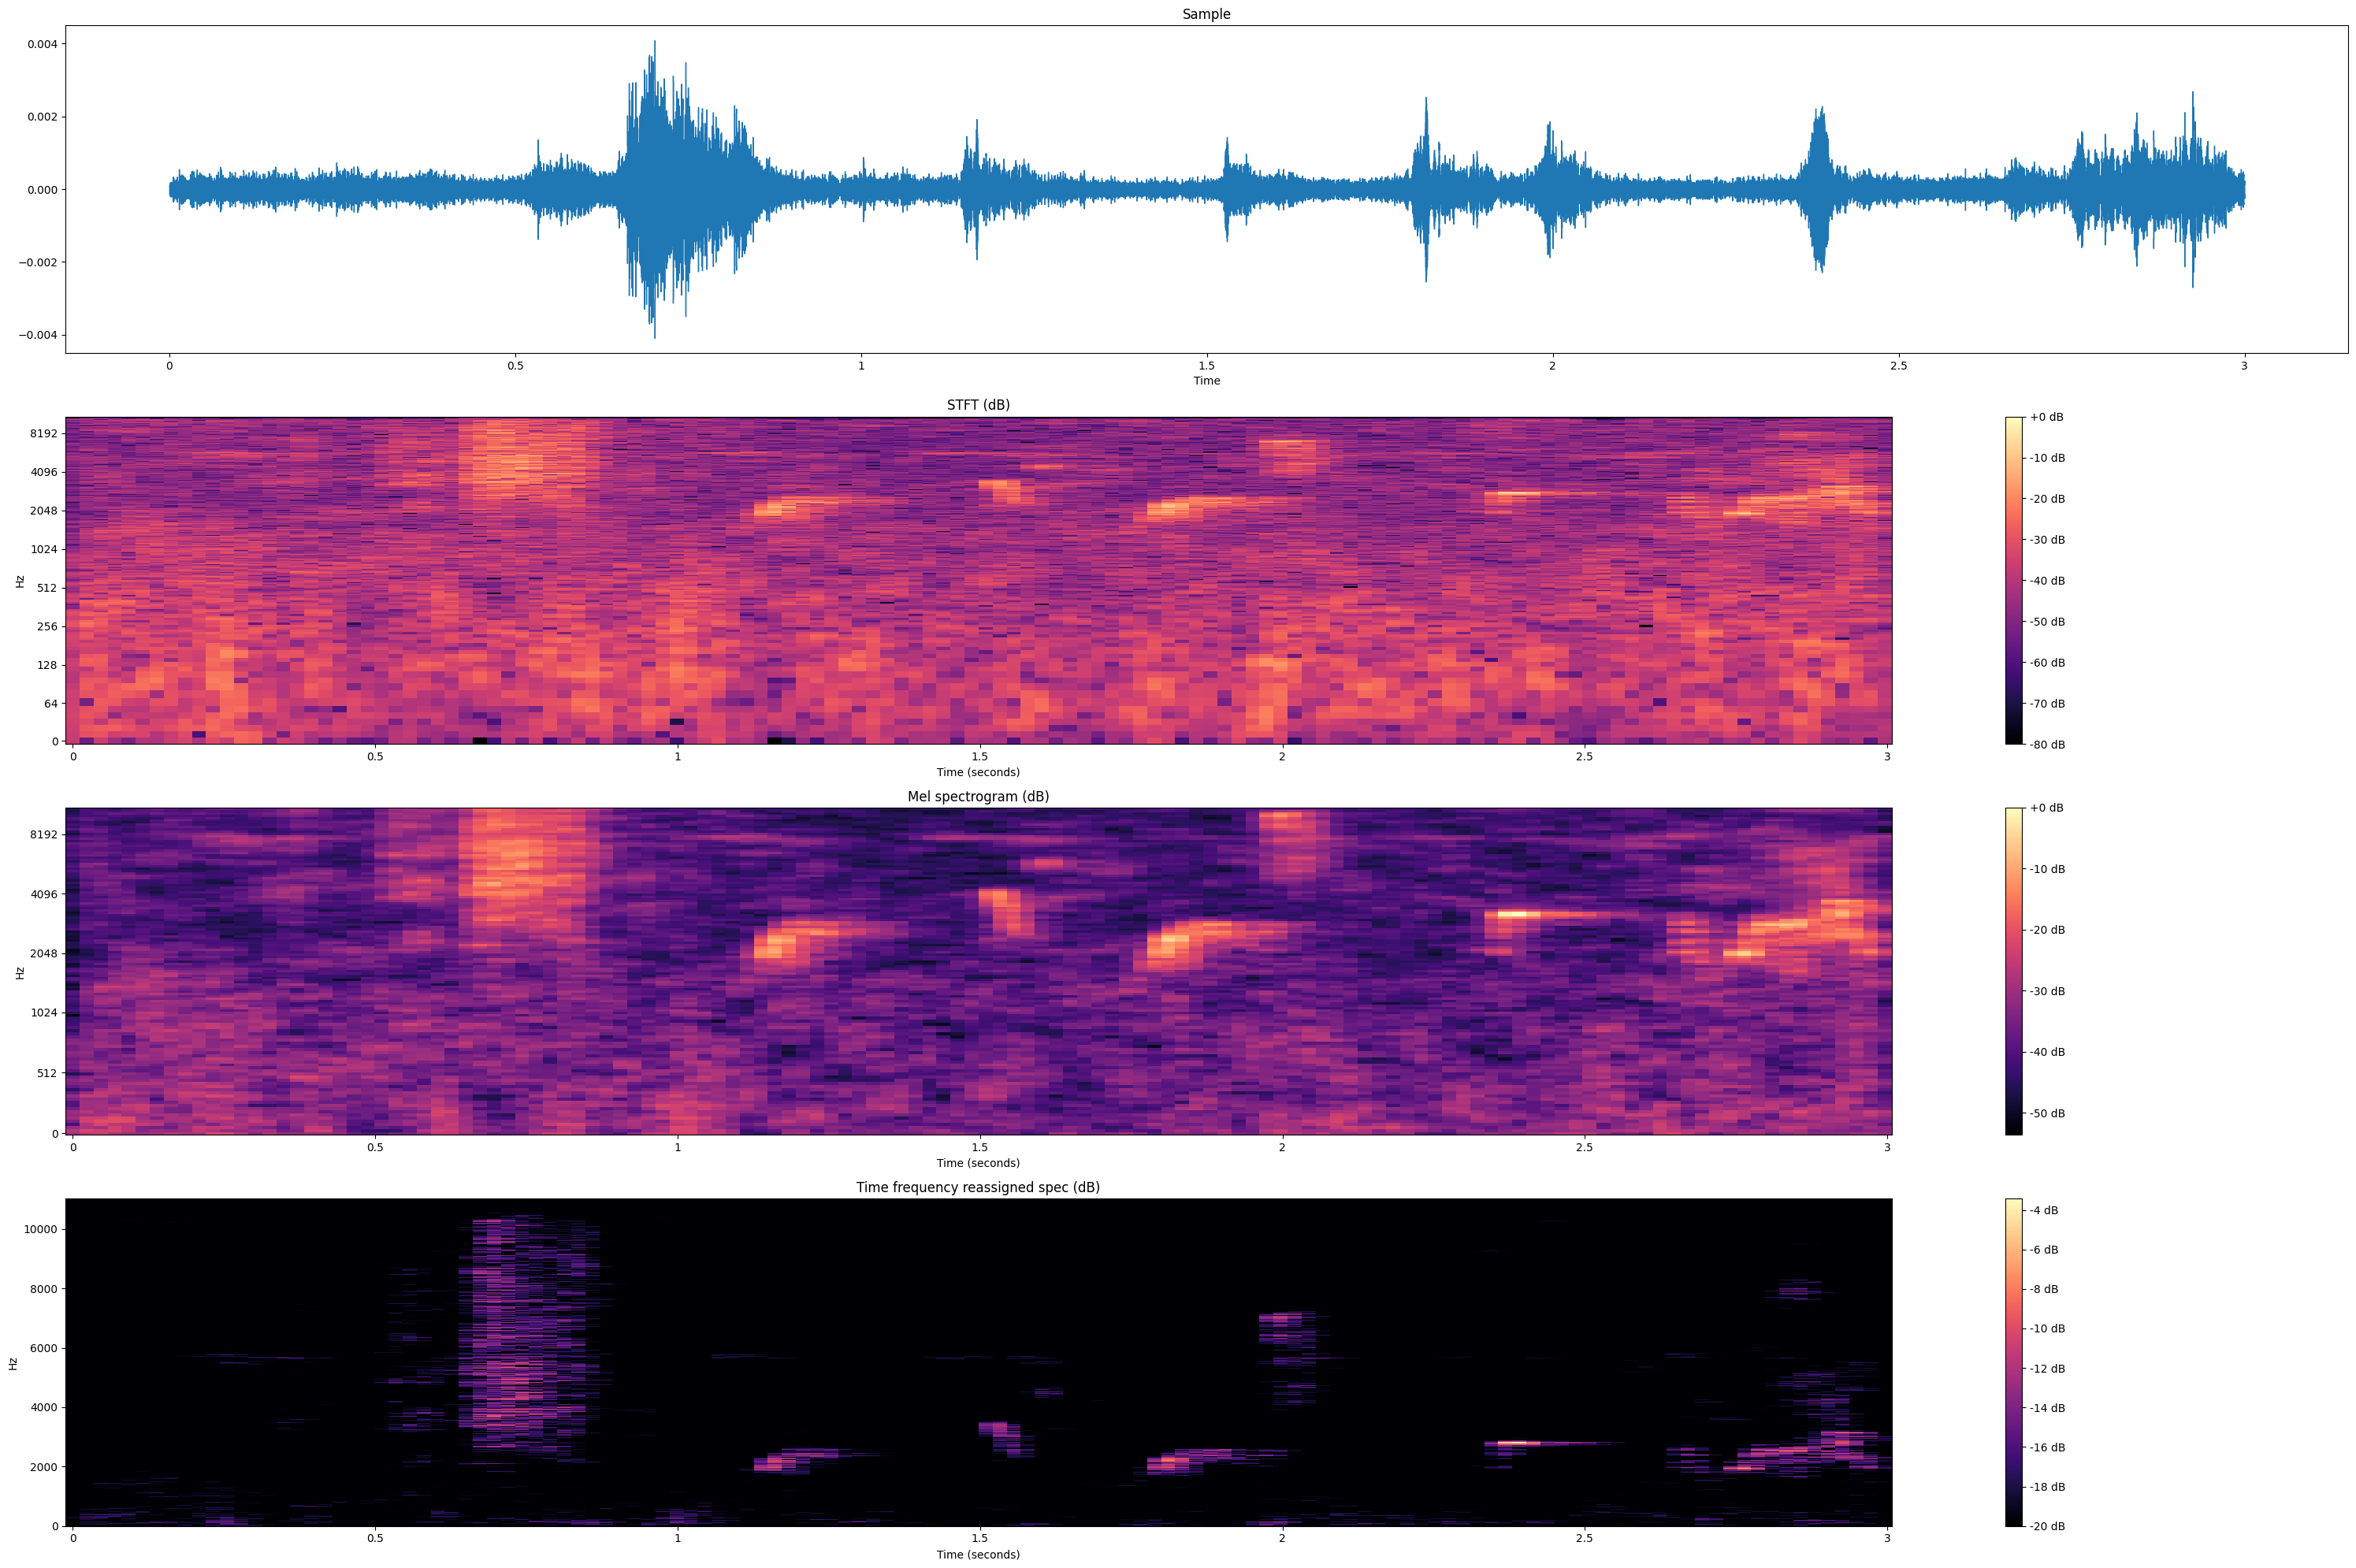

In [11]:
y_nr = nr.reduce_noise(y=y, sr=sr, prop_decrease=0.9)

# Display spectrogram
show_specs(y_nr, sr)
display(Audio(y_nr, rate=sr, autoplay=False))

### High pass filter
remove mic rumble, wind and other low frequencies.

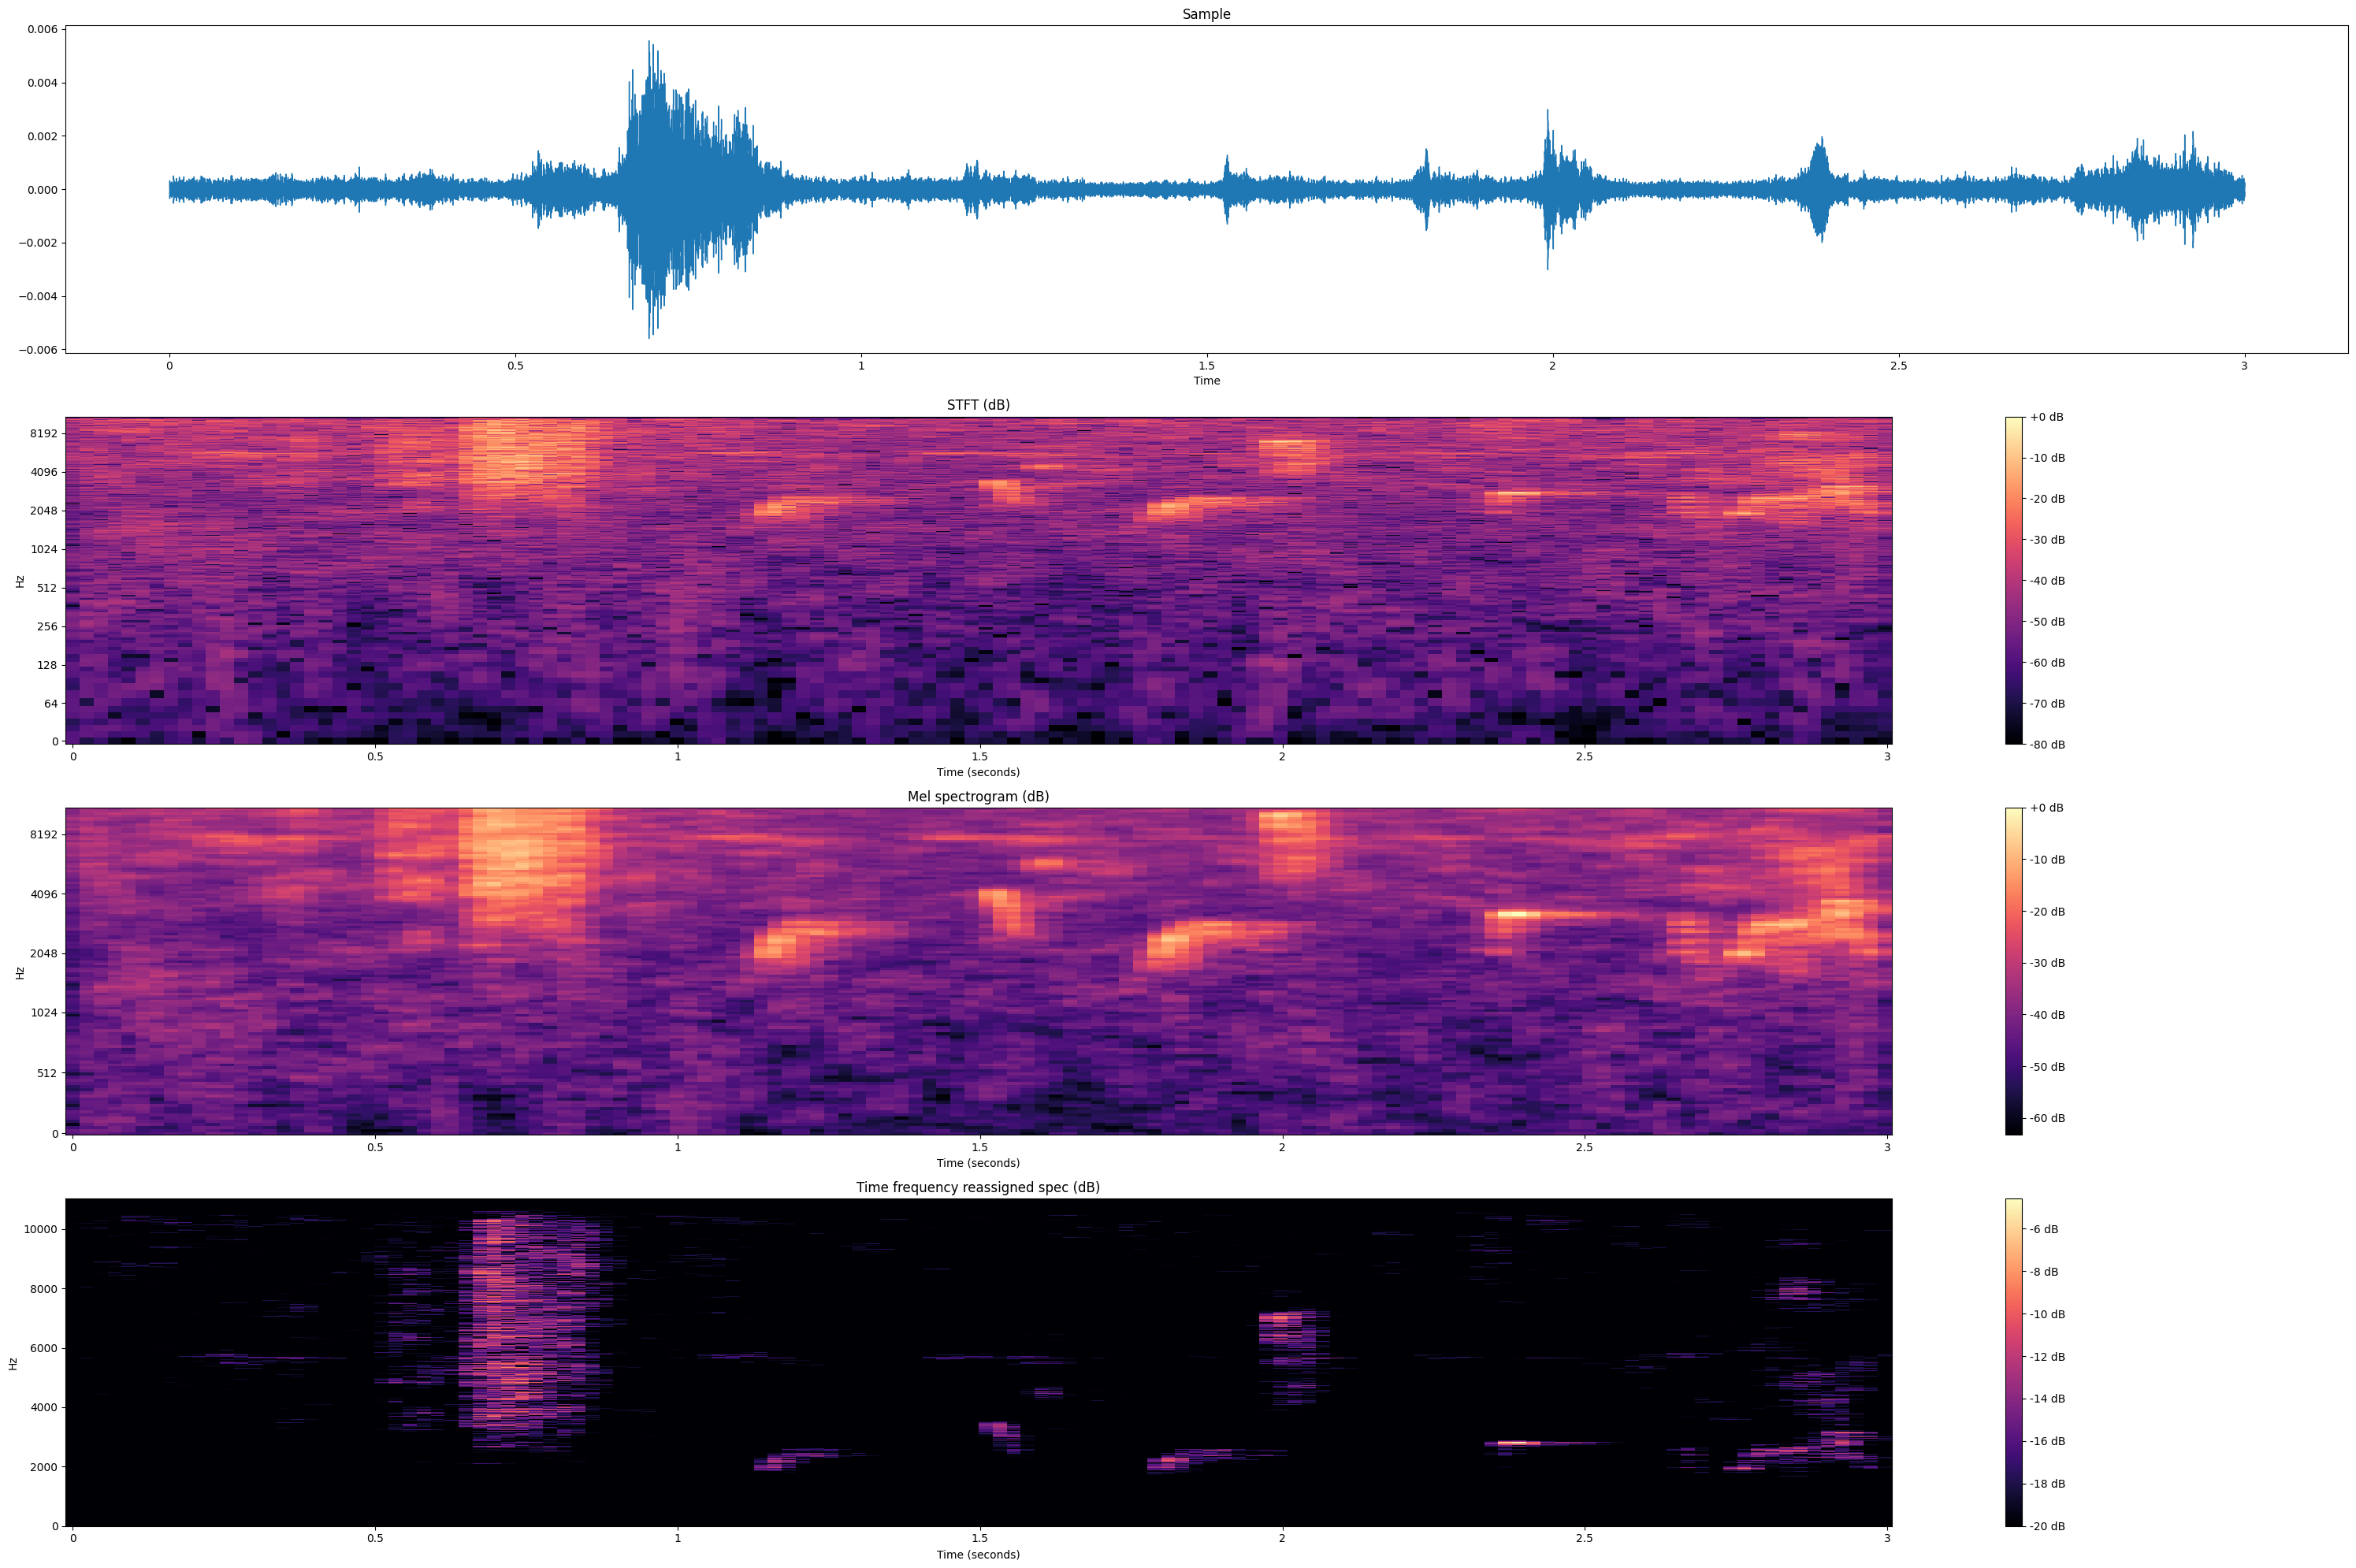

In [12]:
y_hp = librosa.effects.preemphasis(y_nr)
# Display spectrogram
show_specs(y_hp, sr)
display(Audio(y_hp, rate=sr, autoplay=False))

### Normalize volume

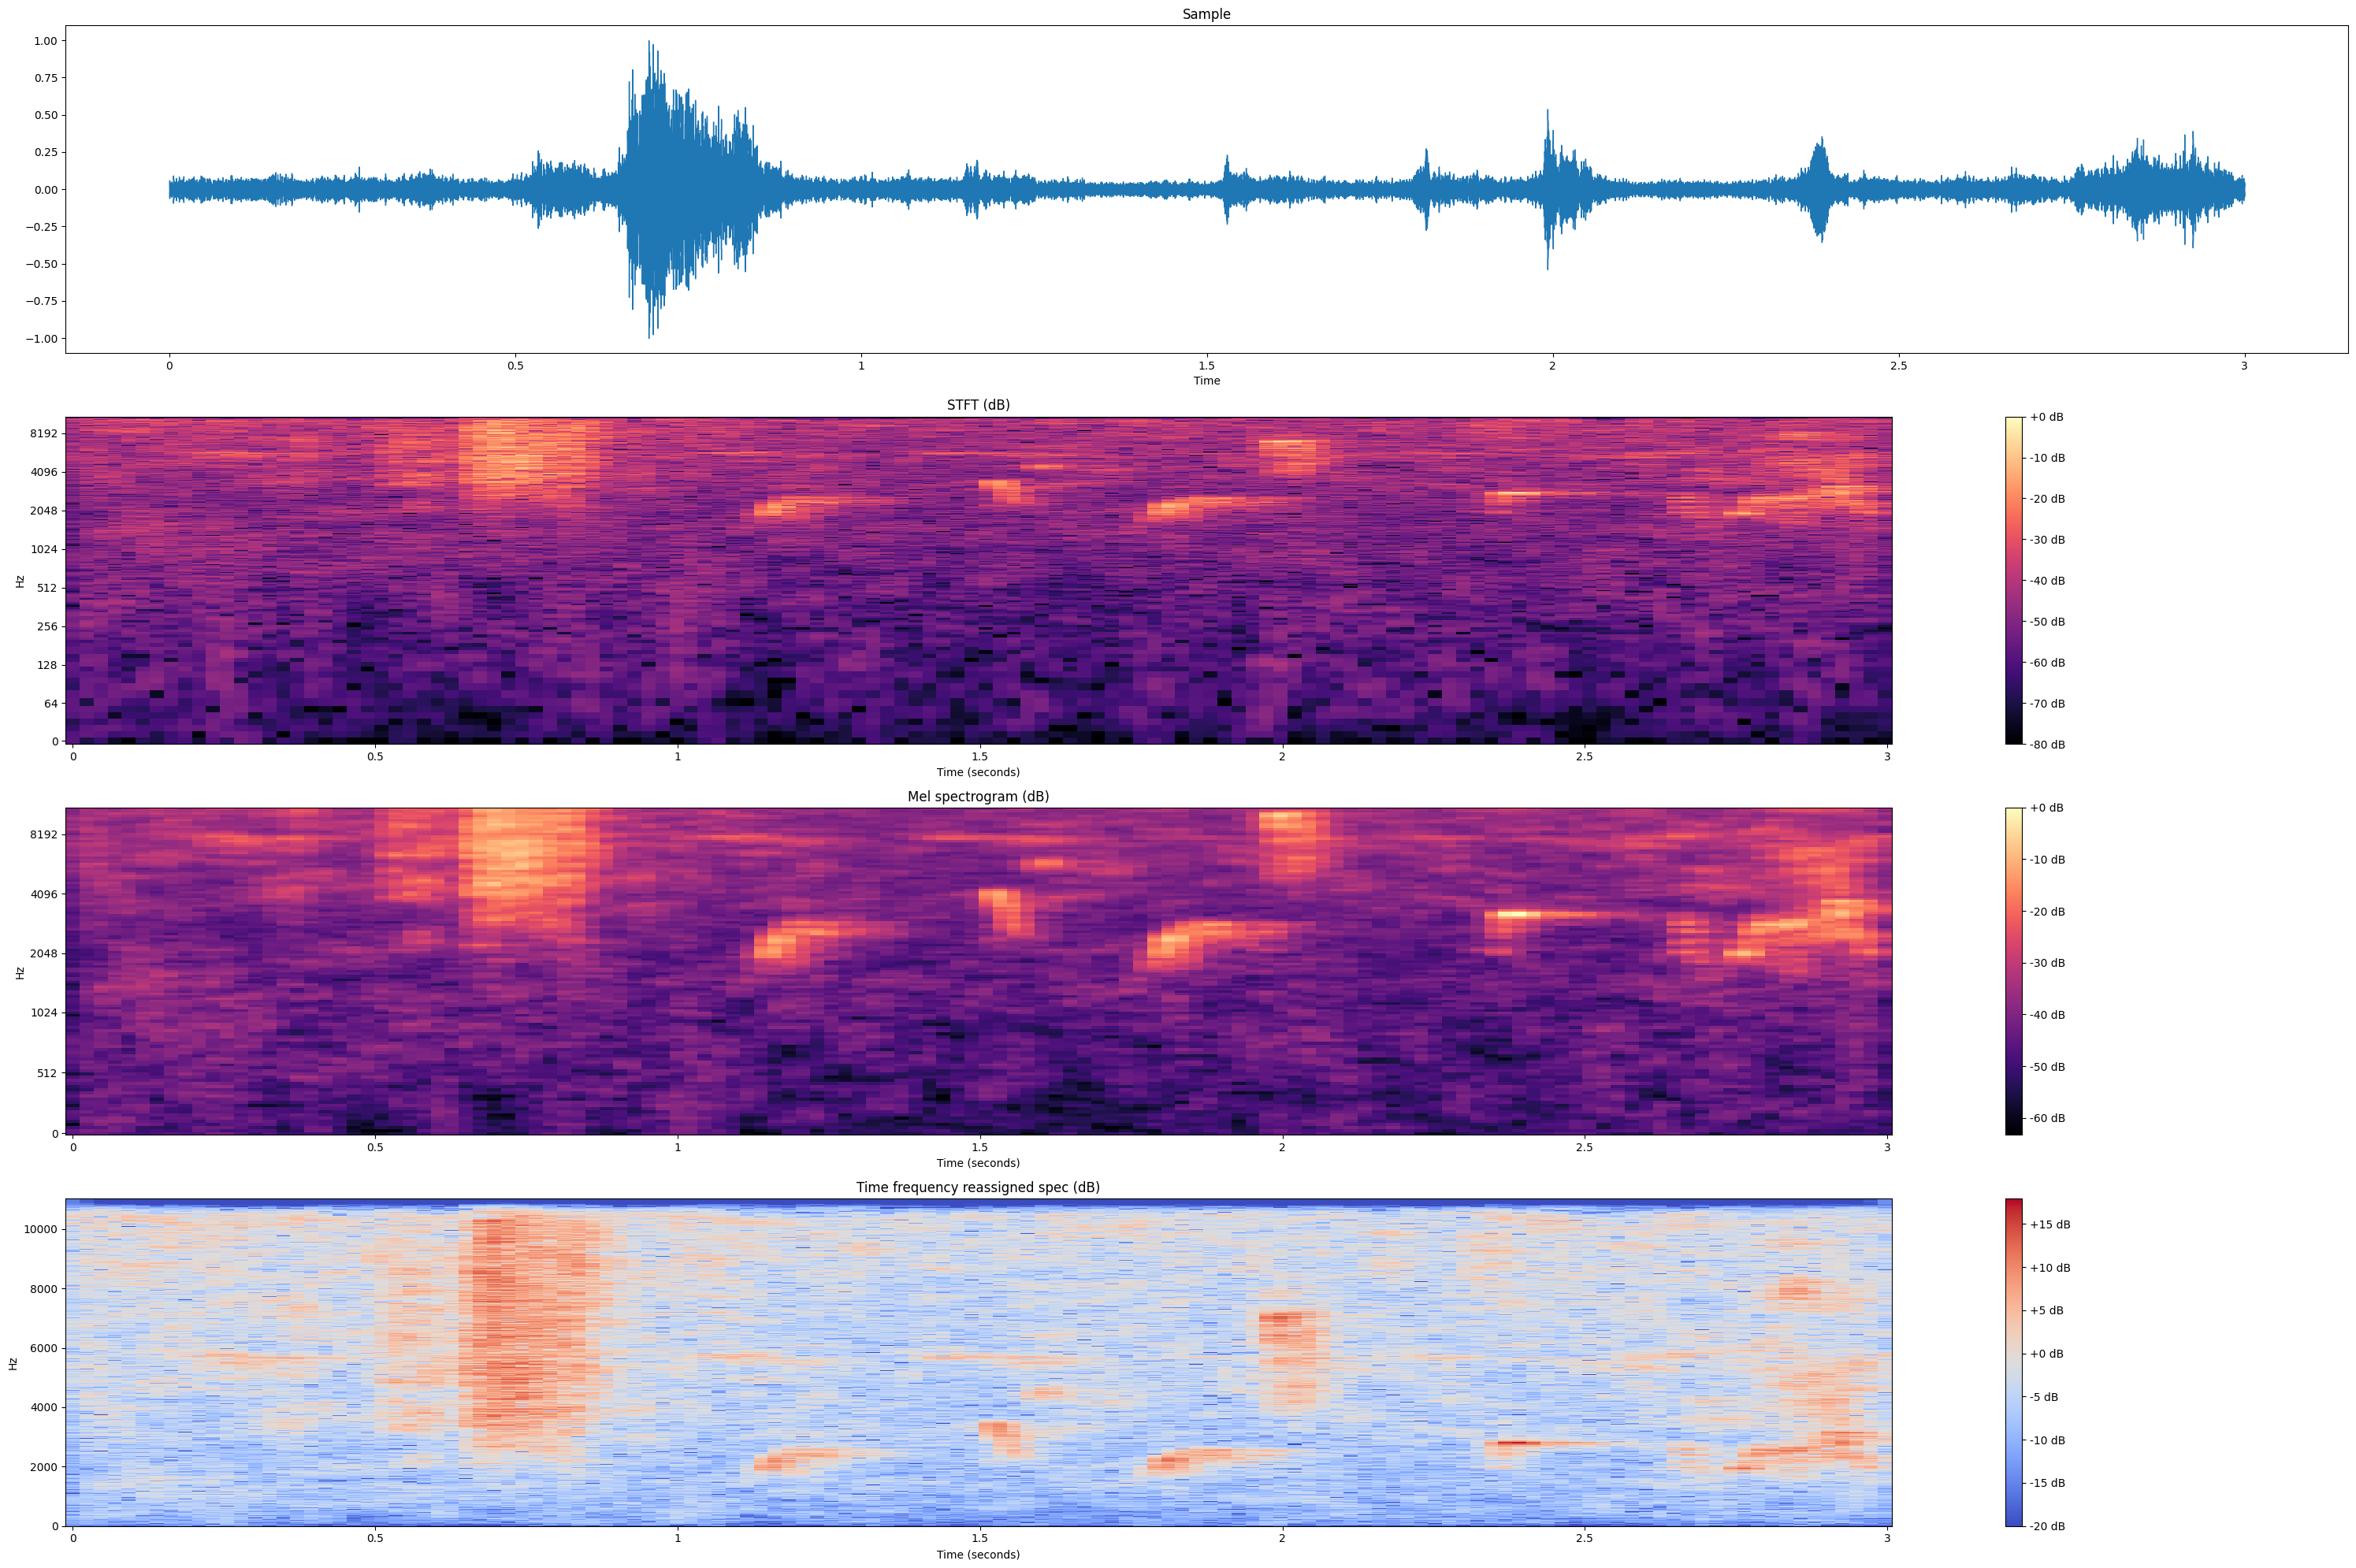

In [13]:
y_norm = librosa.util.normalize(y_hp)

# Display spectrogram
show_specs(y_norm, sr)
display(Audio(y_norm, rate=sr, autoplay=False))

In [14]:
def preprocess_audio(path, center_time, duration=3.0, sr_target=22050):
    y, sr = load_sample(path, center_time, duration, sr_target)
    y = nr.reduce_noise(y=y, sr=sr, prop_decrease=0.9, stationary=True)
    y = librosa.effects.preemphasis(y)
    y = librosa.util.normalize(y)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512,
                                         n_mels=128, fmin=280, fmax=7600)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db, y

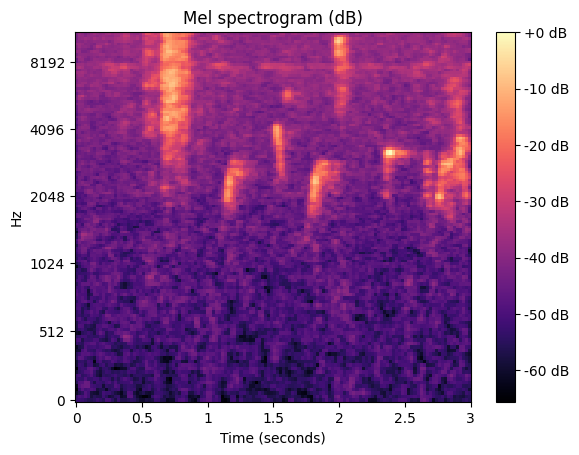

In [15]:
# get spec
mel_db, y = preprocess_audio(example_file, center_time, dur)

# Display spectrogram
plt.figure()
librosa.display.specshow(mel_db, sr=sr, x_axis='s', y_axis='mel')
plt.title('Mel spectrogram (dB)')
plt.colorbar(format='%+2.0f dB')
display(Audio(y, rate=sr, autoplay=False))